# SSD Object Detection — Oxford-IIIT Pet


- 데이터셋: Oxford-IIIT Pet Dataset
- 목적: 객체 탐지(Object Detection) 실습
- 모델: **SSD300 (VGG16 Backbone)**


## 0. 라이브러리 Import 및 디바이스 설정

In [1]:
# 표준 라이브러리
import os
import math
import random
import sys
from pathlib import Path
from glob import glob                 # 이미지 / XML 경로 수집용
import csv
import xml.etree.ElementTree as ET    # XML 어노테이션 파싱용

# 수치 연산 / 데이터 처리
import numpy as np
import pandas as pd

# 이미지 처리
import cv2
from PIL import Image

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 머신러닝 / 통계
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

# PyTorch & TorchVision
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

# Object Detection 모델 / 연산
from torchvision.models.detection import (
    ssd300_vgg16,
    fasterrcnn_resnet50_fpn,
)
from torchvision.ops import box_iou, nms          # IoU 계산, NMS
from torchvision.utils import draw_bounding_boxes # 박스 시각화

# 기타 유틸
from tqdm.auto import tqdm                        # 노트북/콘솔 공용 progress bar

# ------------------------------------------------
# (이번 미션에서는 안 쓸 가능성이 높은 import 후보)
#   필요해지면 주석 해제해서 사용
# ------------------------------------------------
# from pytorch_grad_cam import (
#     GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
#     AblationCAM, XGradCAM, EigenCAM, FullGrad,
# )
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# 버전 출력 (환경 체크용)
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"OpenCV: {cv2.__version__}")

PyTorch: 2.9.1
NumPy: 1.26.4
Pandas: 2.3.3
OpenCV: 4.10.0


/opt/anaconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device():
    """
    사용 가능한 연산 장치를 자동으로 탐지하여 반환하는 함수.

    동작 우선순위:
    1. CUDA GPU가 존재하면 'cuda' 장치를 반환
    2. (Mac 전용) Apple Silicon MPS 가속기가 가능하면 'mps' 장치를 반환
    3. 위 두 옵션이 모두 없을 경우 CPU 장치를 반환

    Returns:
        torch.device: 선택된 연산 장치 (cuda / mps / cpu)
    """
    # 1) CUDA (Colab or PC)
    # (코랩 설정 필요: 메뉴 - 런타임 - 런타임 유형 변경 - 하드웨어 가속기)
    if torch.cuda.is_available():
        print("CUDA GPU detected.")
        return torch.device("cuda")

    # 2) Apple Silicon (Local Mac)
    if torch.backends.mps.is_available():
        print("Apple MPS GPU detected.")
        return torch.device("mps")

    # 3) CPU fallback
    print("No GPU detected. Using CPU.")
    return torch.device("cpu")


device = get_device()
print(f"Using device: {device}")

Apple MPS GPU detected.
Using device: mps


## 1. EDA & Annotation 이해

### 1.1 데이터 다운로드 & 경로 설정

Oxford-IIIT Pet Dataset을 KaggleHub를 통해 다운로드합니다.  
이 데이터셋은 **이미지(`images/`)**와 **제공된 bounding box annotation(`annotations/xmls`)**으로 구성됩니다.

- `trainval.txt`: Train/Validation 이미지 정보  
- `test.txt`: Test 이미지 정보  
- `xmls/`: 각 이미지에 대한 bounding box annotation(XML)

이 단계에서는:
1. KaggleHub로 데이터 다운로드  
2. 경로를 `Path` 객체로 통일  
3. Train/Val/Test 리스트 파일을 DataFrame으로 로드  
4. XML 개수 확인  
을 수행합니다.

In [3]:
import kagglehub

# 데이터셋 다운로드
dataset_root = kagglehub.dataset_download(
    "zippyz/cats-and-dogs-breeds-classification-oxford-dataset"
)
print("Dataset root:", dataset_root)

Dataset root: /Users/youuchul/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1


In [4]:
# Path 객체로 통일
dataset_root = Path(dataset_root)

# 주요 디렉토리
image_dir = dataset_root / "images" / "images"
xml_dir   = dataset_root / "annotations" / "annotations" / "xmls"

trainval_file = dataset_root / "annotations" / "annotations" / "trainval.txt"# 폴더명 / 파일명 확인 후 작성
test_file     = dataset_root / "annotations" / "annotations" / "test.txt"# 폴더명 / 파일명 확인 후 작성

print("Image dir:", image_dir)
print("XML dir:", xml_dir)
print("trainval_file:", trainval_file)
print("test_file:", test_file)

# ------------------------------------------------------------
# Train / Validation 파일 읽기
# ------------------------------------------------------------
df_trainval = pd.read_csv(trainval_file, sep=r"\s+", header=None)
df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]

df_test = pd.read_csv(test_file, sep=r"\s+", header=None)
df_test.columns = ["Image", "ClassID", "Species", "BreedID"]

# ------------------------------------------------------------
# 데이터 개수 확인
# ------------------------------------------------------------
print(f"\nTrain/Validation 데이터 수: {len(df_trainval)}")
print(f"Test 데이터 수: {len(df_test)}")

# XML 파일 개수 확인
xml_files = sorted([f for f in xml_dir.iterdir() if f.suffix == ".xml"])
print(f"XML 파일 개수: {len(xml_files)}")

# ------------------------------------------------------------
# sanity check: 이미지 파일 존재 여부
# ------------------------------------------------------------
print("\n샘플 이미지 파일명:", df_trainval['Image'].iloc[0])
print("실제 이미지 경로:", image_dir / (df_trainval['Image'].iloc[0] + ".jpg"))

Image dir: /Users/youuchul/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/images/images
XML dir: /Users/youuchul/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/annotations/annotations/xmls
trainval_file: /Users/youuchul/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/annotations/annotations/trainval.txt
test_file: /Users/youuchul/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/annotations/annotations/test.txt

Train/Validation 데이터 수: 3680
Test 데이터 수: 3669
XML 파일 개수: 3686

샘플 이미지 파일명: Abyssinian_100
실제 이미지 경로: /Users/youuchul/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/images/images/Abyssinian_100.jpg


## 2.1 Train/Validation/Test 기본 통계 (TXT 기반)

- path 확인 중 파일 하나 선정하여 불러옴

In [5]:
# ============================
# 샘플 XML 파일 선택
# ============================
sample_image_id = df_trainval["Image"].iloc[0]  # 예: "Abyssinian_100"
sample_xml_path = xml_dir / f"{sample_image_id}.xml"

print("샘플 이미지 ID :", sample_image_id)
print("샘플 XML 경로  :", sample_xml_path)

# ============================
# XML 파싱
# ============================
tree = ET.parse(sample_xml_path)
root = tree.getroot()

print("\n[ROOT TAG]")
print(root.tag)  # 보통 'annotation'

# 자식 태그 이름 한 번 훑어보기
print("\n[자식 태그들]")
for child in root:
    print("-", child.tag)

샘플 이미지 ID : Abyssinian_100
샘플 XML 경로  : /Users/youuchul/.cache/kagglehub/datasets/zippyz/cats-and-dogs-breeds-classification-oxford-dataset/versions/1/annotations/annotations/xmls/Abyssinian_100.xml

[ROOT TAG]
annotation

[자식 태그들]
- folder
- filename
- source
- size
- segmented
- object


In [6]:
# ============================
# 파일이름 정보 파싱
# ============================
filename_tag = root.find("filename")
print(filename_tag.text)
# ============================
# 이미지 크기(size) 정보 파싱
# ============================
size_tag = root.find("size")
img_width = int(size_tag.find("width").text)
img_height = int(size_tag.find("height").text)

print(f"이미지 크기: width={img_width}, height={img_height}")

# ============================
# object / bndbox 정보 파싱
# ============================
boxes = []

for obj in root.findall("object"):
    name = obj.find("name").text  # 품종 이름 (예: 'Abyssinian')
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)

    boxes.append({
        "class_name": name,
        "xmin": xmin,
        "ymin": ymin,
        "xmax": xmax,
        "ymax": ymax,
    })

print("\n[파싱된 bounding box 리스트]")
for b in boxes:
    print(b)

Abyssinian_100.jpg
이미지 크기: width=394, height=500

[파싱된 bounding box 리스트]
{'class_name': 'cat', 'xmin': 151, 'ymin': 71, 'xmax': 335, 'ymax': 267}


In [7]:
# ----------------------------------
# Species EDA (TrainVal / Test 집계)
# ----------------------------------
species_counts_train = df_trainval["Species"].value_counts().reset_index()
species_counts_train.columns = ["Species", "Count"]

species_counts_test = df_test["Species"].value_counts().reset_index()
species_counts_test.columns = ["Species", "Count"]

# Species 매핑 (1=Cat, 2=Dog)
species_map = {1: "Cat", 2: "Dog"}
species_counts_train["SpeciesName"] = species_counts_train["Species"].map(species_map)
species_counts_test["SpeciesName"] = species_counts_test["Species"].map(species_map)

# 데이터셋 복사
df_species_tv = species_counts_train.copy()
df_species_test = species_counts_test.copy()

# ----------------------------------
# Plotly Subplots: 왼쪽 Pie, 오른쪽 Table (둘 다 TrainVal 기준)
# ----------------------------------
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "domain"}, {"type": "table"}]],  # domain = pie/donut
    column_widths=[0.4, 0.6],
    horizontal_spacing=0.08,
)

# 왼쪽: Train/Val 기준 Pie Chart
fig.add_trace(
    go.Pie(
        labels=df_species_tv["SpeciesName"],
        values=df_species_tv["Count"],
        hole=0.3,
        textinfo="label+value+percent",  # 라벨 + 개수 + 비율
        hovertemplate="Species: %{label}<br>Count: %{value}<br>Ratio: %{percent}<extra></extra>",
        name="Train/Val",
    ),
    row=1,
    col=1,
)

# 오른쪽: TrainVal 테이블 (Species, Count, SpeciesName)
fig.add_trace(
    go.Table(
        header=dict(
            values=list(df_species_tv.columns),
            fill_color="lightgrey",
            align="center",
            font=dict(size=12),
        ),
        cells=dict(
            values=[df_species_tv[col] for col in df_species_tv.columns],
            align="center",
        ),
    ),
    row=1,
    col=2,
)

fig.update_layout(
    title_text="Species Distribution (Cat vs Dog) — TrainVal",
    height=500,
    showlegend=False,
)

fig.show()

# ----------------------------------
# Plotly Subplots: 왼쪽 Pie, 오른쪽 Table (Test 기준)
# ----------------------------------
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "domain"}, {"type": "table"}]],
    column_widths=[0.4, 0.6],
    horizontal_spacing=0.08,
)

# 왼쪽: Test 기준 Pie Chart
fig.add_trace(
    go.Pie(
        labels=df_species_test["SpeciesName"],
        values=df_species_test["Count"],
        hole=0.3,
        textinfo="label+value+percent",
        hovertemplate="Species: %{label}<br>Count: %{value}<br>Ratio: %{percent}<extra></extra>",
        name="Test",
    ),
    row=1, col=1
)

# 오른쪽: Test 테이블
fig.add_trace(
    go.Table(
        header=dict(
            values=list(df_species_test.columns),
            fill_color="lightgrey",
            align="center",
            font=dict(size=12),
        ),
        cells=dict(
            values=[df_species_test[col] for col in df_species_test.columns],
            align="center",
        ),
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Species Distribution (Cat vs Dog) — Test Set",
    height=500,
    showlegend=False,
)

fig.show()

- Trainval과 Test 데이터셋의 클래스 비중이 균일함 (Dog 기준 0.1%p 차이)

In [8]:
# ------------------------------------------------------------
# 실제 이미지 크기 정보 수집
# ------------------------------------------------------------

image_paths = sorted(image_dir.glob("*.jpg"))

img_sizes = {
    "filename": [],
    "width": [],
    "height": [],
    "aspect_ratio": [],
}

for path in tqdm(image_paths):
    img = Image.open(path)
    w, h = img.size

    img_sizes["filename"].append(path.stem)
    img_sizes["width"].append(w)
    img_sizes["height"].append(h)
    img_sizes["aspect_ratio"].append(w / h) # SSD 300을 활용하므로, 종횡비가 다양하면 왜곡이 생길 수 있음

df_img = pd.DataFrame(img_sizes)
df_img.head()

100%|██████████| 7390/7390 [00:02<00:00, 3578.03it/s]


,filename,width,height,aspect_ratio
0,Abyssinian_1,600,400,1.500000
1,Abyssinian_10,375,500,0.750000
2,Abyssinian_100,394,500,0.788000
3,Abyssinian_101,450,313,1.437700
4,Abyssinian_102,500,465,1.075269


In [9]:
# --------------------------
# 실제 이미지 크기 분포 시각화
# --------------------------
px.histogram(df_img, x="width", nbins=30,
             title="Image Width Distribution").show()

px.histogram(df_img, x="height", nbins=30,
             title="Image Height Distribution").show()

px.histogram(df_img, x="aspect_ratio", nbins=30,
             title="Image Aspect Ratio Distribution").show()

In [10]:
ratio_range = df_img[(df_img["aspect_ratio"].between(0.9, 1.1))]
(count := len(ratio_range)), (count / len(df_img) * 100)

(484, 6.549391069012178)

- 이미지 크기가 다양하고, 왜곡이 발생하지 않는 0.9 ~ 1.1 종횡비를 보이는 이미지는 7%에 불과함.
- ssd300에 바로 넣으면 왜곡때문에 성능이 떨어질 가능성이 높음.
- letterbox transform 코드(PIL/torchvision 버전), aspect-ratio-aware augmentation 패키지,crop 같은 전처리를 고려할 필요가 있음

### 후속 작업 전 이미지와 xml 수를 다시 확인하고 매칭작업

In [11]:
# ------------------------------------------------------------
# 1) trainval.txt 기준으로 XML 매칭
#    - df_trainval['Image'] : "Abyssinian_1" 이런 ID
#    - xml_dir / f"{img_id}.xml" 이 실제 존재하는 경우만 사용
# ------------------------------------------------------------
train_image_ids = df_trainval["Image"].tolist()

valid_pairs = []   # (img_id, xml_path)
missing_xml = []   # xml 없는 이미지들

for img_id in train_image_ids:
    xml_path = xml_dir / f"{img_id}.xml"
    if xml_path.exists():
        valid_pairs.append((img_id, xml_path))
    else:
        missing_xml.append(img_id)

print(f"Train/Val 이미지 수          : {len(train_image_ids)}")
print(f"XML 존재하는 Train/Val 수    : {len(valid_pairs)}")
print(f"XML 없는 Train/Val 이미지 수 : {len(missing_xml)}")

Train/Val 이미지 수          : 3680
XML 존재하는 Train/Val 수    : 3671
XML 없는 Train/Val 이미지 수 : 9


In [12]:
# 파싱 함수
def parse_annotation_xml(xml_path: Path):
    """
    주어진 XML(annotation) 파일을 파싱하여
    이미지 크기 및 bounding box 리스트를 반환하는 함수.

    Returns
    -------
    dict:
        {
            "filename": str,
            "width": int,
            "height": int,
            "boxes": [
                {"class_name": str, "xmin": int, "ymin": int, "xmax": int, "ymax": int},
                ...
            ]
        }
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 파일명 (옵션)
    filename_tag = root.find("filename")
    filename = filename_tag.text if filename_tag is not None else xml_path.stem

    # 이미지 크기
    size_tag = root.find("size")
    width = int(size_tag.find("width").text)
    height = int(size_tag.find("height").text)

    # bounding boxes
    boxes = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        boxes.append({
            "class_name": name,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
        })

    return {
        "filename": filename,
        "width": width,
        "height": height,
        "boxes": boxes,
    }

# 함수 테스트
parsed = parse_annotation_xml(sample_xml_path)
parsed

{'filename': 'Abyssinian_100.jpg',
 'width': 394,
 'height': 500,
 'boxes': [{'class_name': 'cat',
   'xmin': 151,
   'ymin': 71,
   'xmax': 335,
   'ymax': 267}]}

In [13]:
# ------------------------------------------------------------
# 2) 유효한 (Image, XML) 쌍만 파싱
# ------------------------------------------------------------
all_annots = []

for img_id, xml_path in valid_pairs:
    parsed = parse_annotation_xml(xml_path)
    # sanity check: 파일명과 img_id가 안 맞으면 로그 찍기
    if not parsed["filename"].startswith(img_id):
        print(f"⚠ filename mismatch: img_id={img_id}, parsed={parsed['filename']}")
    all_annots.append(parsed)

print(f"총 사용 가능한 annotation 수 (TrainVal 중 XML 존재): {len(all_annots)}")
all_annots[0]

총 사용 가능한 annotation 수 (TrainVal 중 XML 존재): 3671


{'filename': 'Abyssinian_100.jpg',
 'width': 394,
 'height': 500,
 'boxes': [{'class_name': 'cat',
   'xmin': 151,
   'ymin': 71,
   'xmax': 335,
   'ymax': 267}]}

- all_annots 변수에 유효한 쌍만 담음

In [14]:
# ------------------------------------------------------------
# bounding box 단위로 펼쳐서 DataFrame 만들기
# ------------------------------------------------------------
box_records = []

for ann in all_annots: # all_annots: #파싱된 어노테이션 리스트
    filename = ann["filename"]
    img_w = ann["width"]
    img_h = ann["height"]

    for box in ann["boxes"]:
        xmin = box["xmin"]
        ymin = box["ymin"]
        xmax = box["xmax"]
        ymax = box["ymax"]

        bw = xmax - xmin
        bh = ymax - ymin
        area = bw * bh
        aspect = bw / bh if bh > 0 else None

        box_records.append({
            "filename": filename,
            "img_width": img_w,
            "img_height": img_h,
            "box_width": bw,
            "box_height": bh,
            "box_area": area,
            "box_aspect": aspect,
            "class_name": box["class_name"],
            "num_boxes": len(ann["boxes"]),
        })

df_boxes = pd.DataFrame(box_records)
df_boxes.head()

,filename,img_width,img_height,box_width,box_height,box_area,box_aspect,class_name,num_boxes
0,Abyssinian_100.jpg,394,500,184,196,36064,0.938776,cat,1
1,Abyssinian_101.jpg,450,313,265,199,52735,1.331658,cat,1
2,Abyssinian_102.jpg,500,465,302,293,88486,1.030717,cat,1
3,Abyssinian_103.jpg,500,351,121,128,15488,0.945312,cat,1
4,Abyssinian_105.jpg,500,375,136,126,17136,1.079365,cat,1


In [15]:
df_boxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    3672 non-null   object 
 1   img_width   3672 non-null   int64  
 2   img_height  3672 non-null   int64  
 3   box_width   3672 non-null   int64  
 4   box_height  3672 non-null   int64  
 5   box_area    3672 non-null   int64  
 6   box_aspect  3672 non-null   float64
 7   class_name  3672 non-null   object 
 8   num_boxes   3672 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 258.3+ KB


In [16]:
# bbox width / height 분포
px.histogram(df_boxes, x="box_width", nbins=30,
             title="Bounding Box Width Distribution").show()

px.histogram(df_boxes, x="box_height", nbins=30,
             title="Bounding Box Height Distribution").show()

# aspect ratio
px.histogram(df_boxes, x="box_aspect", nbins=30,
             title="Bounding Box Aspect Ratio (width / height)").show()

px.histogram(df_boxes, x="num_boxes",
             title="Number of Bounding Boxes per Image").show()    

- 이미지 당 박스가 1개씩인 것으로 인지하고 있었으나 다른 데이터 존재 확인

In [17]:
df_boxes['num_boxes'].describe()

count    3672.000000
mean        1.000545
std         0.023335
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: num_boxes, dtype: float64

In [18]:
df_boxes[df_boxes["num_boxes"] > 1]

,filename,img_width,img_height,box_width,box_height,box_area,box_aspect,class_name,num_boxes
254,Bengal_105.jpg,500,466,62,43,2666,1.441860,cat,2
255,Bengal_105.jpg,500,466,54,29,1566,1.862069,cat,2


Filename: Bengal_105.jpg
{'filename': 'Bengal_105.jpg', 'width': 500, 'height': 466, 'boxes': [{'class_name': 'cat', 'xmin': 49, 'ymin': 125, 'xmax': 111, 'ymax': 168}, {'class_name': 'cat', 'xmin': 397, 'ymin': 103, 'xmax': 451, 'ymax': 132}]}


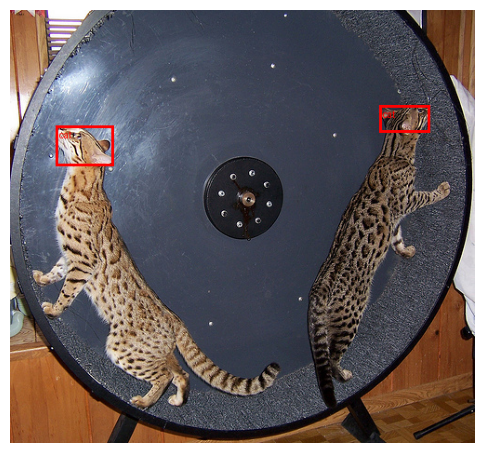

In [19]:
# 1) 대상 파일 선택
target_filename = df_boxes[df_boxes["num_boxes"] == 2]["filename"].iloc[0]
print("Filename:", target_filename)

# 2) 이미지 경로 + XML 경로
img_path = image_dir / target_filename
xml_path = xml_dir / (Path(target_filename).stem + ".xml")

# 3) annotation 파싱
ann = parse_annotation_xml(xml_path)
print(ann)

# 4) 원본 이미지 로드
img = Image.open(img_path).convert("RGB")
img_tensor = torchvision.transforms.ToTensor()(img)

# 5) bbox 좌표 Tensor 변환
boxes = []
labels = []
for box in ann["boxes"]:
    boxes.append([box["xmin"], box["ymin"], box["xmax"], box["ymax"]])
    labels.append(box["class_name"])

boxes_tensor = torch.tensor(boxes, dtype=torch.int32)

# 6) bounding box 그리기
img_with_boxes = torchvision.utils.draw_bounding_boxes(
    (img_tensor * 255).to(torch.uint8),
    boxes_tensor,
    labels=labels,
    colors="red",
    width=3,
)

# 7) 시각화
plt.figure(figsize=(6,6))
plt.imshow(img_with_boxes.permute(1, 2, 0))
plt.axis("off")
plt.show()

- 오류는 아닌 것으로 확인
- 추후 모델 성능개선에서 포함/제외 선택이 가능하겠지만 일단은 성능에 큰 영향이 없고 장단점이 있을 것이라 판단하여 데이터 포함

### 1.5 Bounding Box 시각화 예시

- XML 파싱 결과가 실제 이미지와 잘 맞는지 시각적으로 확인
- 랜덤 샘플 3~4장을 그려서 bbox 위치/크기를 검증

샘플 이미지: pug_190


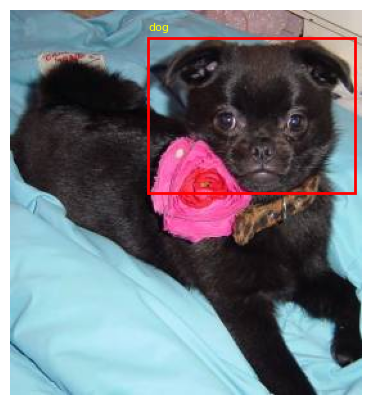

샘플 이미지: Birman_182


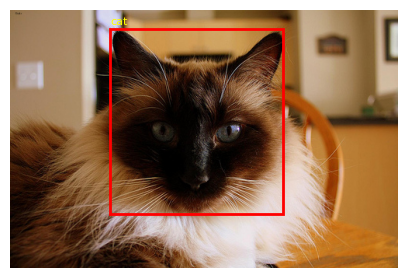

샘플 이미지: wheaten_terrier_169


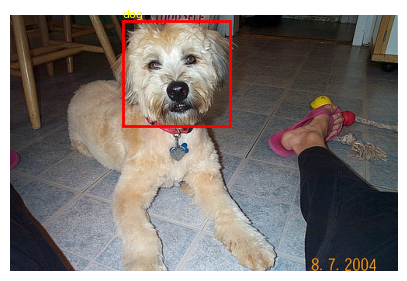

In [20]:
def viz_xml_annotation(img_path: Path, ann: dict):
    """
    원본 XML 기반 annotation을 이용해 이미지에 bounding box를 시각화하는 함수.

    Parameters
    ----------
    img_path : Path
        시각화할 이미지(.jpg) 파일의 경로.
    ann : dict
        parse_annotation_xml() 함수에서 생성된 annotation 딕셔너리.
        {
            "filename": str,
            "width": int,
            "height": int,
            "boxes": [
                {
                    "class_name": str,
                    "xmin": int, "ymin": int,
                    "xmax": int, "ymax": int
                },
                ...
            ]
        }

    Notes
    -----
    - 이 함수는 **EDA 단계**에서 사용한다.
    - Dataset / DataLoader 생성 전, XML 파싱이 정상적으로 되었는지 확인할 때 적합하다.
    - bbox 형태는 dict 기반이며, 아직 tensor로 변환되지 않은 raw 형태이다.
    """
    img = Image.open(img_path).convert("RGB")
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    
    for box in ann["boxes"]:
        xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor="red",
            linewidth=2
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, box["class_name"], color="yellow", fontsize=8)
    ax.axis("off")
    plt.show()

# 랜덤 샘플 3장 정도 확인
for _ in range(3):
    img_id, xml_path = random.choice(valid_pairs)
    ann = parse_annotation_xml(xml_path)
    img_path = image_dir / f"{img_id}.jpg"
    print("샘플 이미지:", img_id)
    viz_xml_annotation(img_path, ann)